## Maximize the likelihood for different values of $\Sigma m_\nu$

First, I create a mock P1D measurement with the covariance matrix of Chabanier et al. (2019, eBOSS DR14), but with the data vector from a Gadget simulation with massive neutrinos ($\Sigma m_\nu$ = 0.3 eV).

Then I setup an emulator with our suite of 30 simulations (all of them with massless neutrinos).

Finally, I setup a likelihood object with several free parameters: 3 cosmological parameters ($A_s$,$n_s$,$\Sigma m_\nu$) and 3 IGM parameters (overall normalization of $<F>$, $T_0$ and $\gamma$, fixed redshift evolution).

I choose then 15 values of neutrino mass in the range $0.0 < \Sigma m_\nu < 1.0$ eV, and for each of these I maximize the likelihood with iminuit, and report the best-fit values, Gaussian errorbars and $\chi^2$.

We recover the degeneracy $\Sigma m_\nu$ - $A_s$, as expected, and we show that we are not very sensitive to the neutrino mass.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from iminuit import Minuit
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label='nu'
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

Sim has neutrinos
read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/nu_sim/sim_plus/paramfile.genic
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 3.2257E-03, A_s = 2.2507E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
# specify redshift range
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [6]:
# get true cosmology in test simulation
sim_cosmo=data.mock_sim.sim_cosmo
true_As=sim_cosmo.InitPower.As
true_ns=sim_cosmo.InitPower.ns
true_H0=sim_cosmo.H0
true_mnu=camb_cosmo.get_mnu(sim_cosmo)
print('true As =',true_As)
print('true ns =',true_ns)
print('true H_0 =',true_H0)
print('true mnu =',true_mnu)

true As = 2.25069e-09
true ns = 0.967565
true H_0 = 67.0
true mnu = 0.30044095238550983


### Maximize likelihood for different values of H_0

In [7]:
# define free likelihood parameters
like_params=["As","ns","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05],[-0.2, 0.2], [-0.5, 0.5], [-0.2, 0.2]]
# choose starting point
theta=np.ones(len(like_params))*0.5

In [8]:
Nmnu=15
mnus=np.linspace(0.0,1.0,Nmnu)
likelihoods=[]
for mnu in mnus:
    cosmo_fid=camb_cosmo.get_cosmology(mnu=mnu)
    camb_model_fid=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_fid)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_fid)
    print('use fiducial cosmology with mnu=',mnu)
    like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,prior_Gauss_rms=0.5)
    likelihoods.append(like)

use fiducial cosmology with mnu= 0.0
use fiducial cosmology with mnu= 0.07142857142857142
use fiducial cosmology with mnu= 0.14285714285714285
use fiducial cosmology with mnu= 0.21428571428571427
use fiducial cosmology with mnu= 0.2857142857142857
use fiducial cosmology with mnu= 0.3571428571428571
use fiducial cosmology with mnu= 0.42857142857142855
use fiducial cosmology with mnu= 0.5
use fiducial cosmology with mnu= 0.5714285714285714
use fiducial cosmology with mnu= 0.6428571428571428
use fiducial cosmology with mnu= 0.7142857142857142
use fiducial cosmology with mnu= 0.7857142857142857
use fiducial cosmology with mnu= 0.8571428571428571
use fiducial cosmology with mnu= 0.9285714285714285
use fiducial cosmology with mnu= 1.0


In [9]:
results=[]
for like in likelihoods:
    ## Evaluate log_prob at random point in parameter space
    chi2_test=like.get_chi2(theta)
    print('starting chi2',chi2_test)
    # setup minuit
    m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)
    # run optimiser
    m.migrad()
    # compute Hesse covariance
    m.hesse()
    # store results from iminuit
    results.append(m)
    min_chi2=like.get_chi2(m.values)
    print('minimum chi2',min_chi2)

starting chi2 32.08643558894897
minimum chi2 1.0387422914895583
starting chi2 24.686524700439744
minimum chi2 0.6917289760401834
starting chi2 16.28346935710518


 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


minimum chi2 0.4285612951824764
starting chi2 12.959297164694254
minimum chi2 0.257617342752231
starting chi2 14.778624674945604
minimum chi2 0.17683278654742446
starting chi2 20.323965006674353
minimum chi2 0.18356570424083707
starting chi2 28.34867197552311
minimum chi2 0.26907920966613147
starting chi2 37.99187885549709
minimum chi2 0.43215130189653234
starting chi2 48.69184621646013
minimum chi2 0.6735824213297432
starting chi2 60.097571691811254
minimum chi2 0.9834779572016494
starting chi2 72.08290535488189
minimum chi2 1.357703752177984
starting chi2 84.29403892839146
minimum chi2 1.7989653387153501
starting chi2 96.04515347039244
minimum chi2 2.28960958509406
starting chi2 108.86223166927691
minimum chi2 2.84290605134037
starting chi2 121.97793448133214
minimum chi2 3.5685406510286093


 /Library/Python/3.7/site-packages/ipykernel_launcher.py:11: HesseFailedWarning:HESSE Failed. Covariance and GlobalCC will not be available


In [10]:
best_fit_chi2=[likelihoods[p].get_chi2(values=results[p].values) for p in range(len(mnus))]
best_fit_As=[likelihoods[p].parameters_from_sampling_point(results[p].values)[0].value for p in range(Nmnu)]
best_fit_ns=[likelihoods[p].parameters_from_sampling_point(results[p].values)[1].value for p in range(Nmnu)]

In [11]:
# convoluted way to get error on As and ns
error_As=[likelihoods[p].parameters_from_sampling_point(results[p].np_values()+results[p].np_errors())[0].value - best_fit_As[p] for p in range(Nmnu) ]
error_ns=[likelihoods[p].parameters_from_sampling_point(results[p].np_values()+results[p].np_errors())[1].value - best_fit_ns[p] for p in range(Nmnu) ]

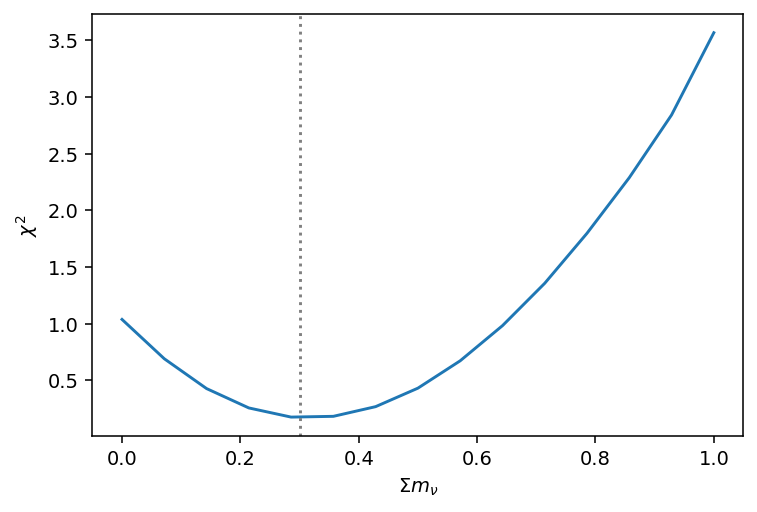

In [12]:
plt.plot(mnus,best_fit_chi2)
plt.axvline(x=true_mnu,ls=':',color='gray')
plt.xlabel(r'$\Sigma m_\nu$')
plt.ylabel(r'$\chi^2$');

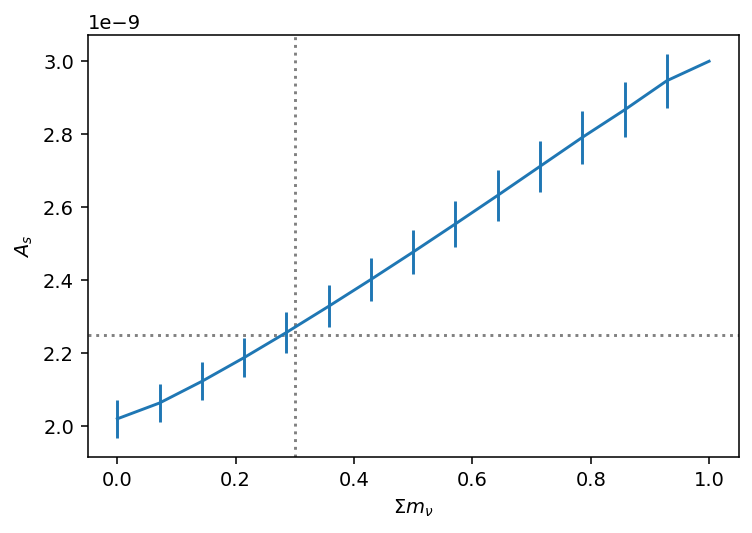

In [13]:
plt.errorbar(mnus,best_fit_As,yerr=error_As)
plt.axvline(x=true_mnu,ls=':',color='gray')
plt.axhline(y=true_As,ls=':',color='gray')
plt.xlabel(r'$\Sigma m_\nu$')
plt.ylabel(r'$A_s$');

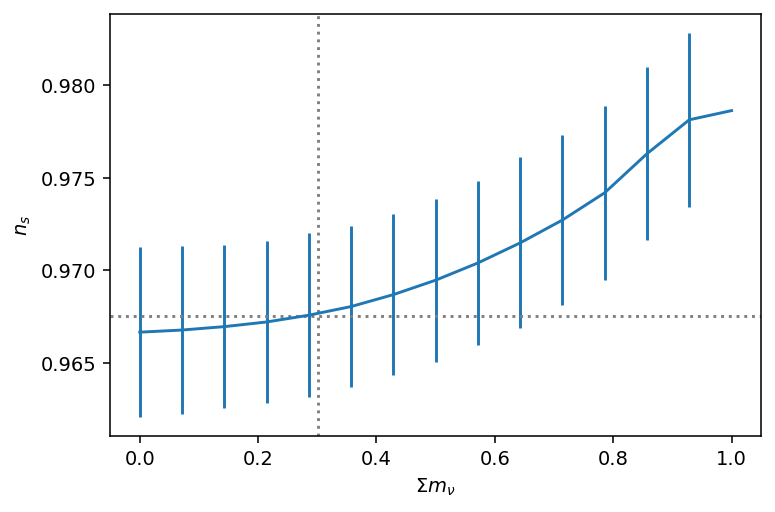

In [14]:
plt.errorbar(mnus,best_fit_ns,yerr=error_ns)
plt.axvline(x=true_mnu,ls=':',color='gray')
plt.axhline(y=true_ns,ls=':',color='gray')
plt.xlabel(r'$\Sigma m_\nu$')
plt.ylabel(r'$n_s$');